# Section 3.1 Single Model Diagnostics
* How can we determine that our MCMC model has converged?*

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
from utils import metropolis_hastings
import scipy.stats as stats
import os
import time
np.random.seed(0)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Learning Objectives
* Understand Hamiltonian Monte Carlo sampler basics
* Visualize and interpret single model diagnostics such as TracePlot, Autocorrelation, and Energy Plot
* Calculate and interpret single model diagnostic calculations 
* Gain profiency with Xarray, NetCDF, and az.InferenceData objects

## MCMC is great but its not perfect
Recall that Monte Carlo Markov Chain are handy mathematical trick that let's us compute posteriors, without needing to compute the denonimator of Bayes rule, but it has tradeoffs. Most notably **finite Monte Carlo Markov Chains are not gauranteed to converge to the true parameter value**

This is not to say finite MCMC chains are always wrong, but it does mean that when using MCMC inference methods it is prudent to check the results diagnostic methods. In this tutorial we'll cover both numerical and visual methods

### Desirable characteristics in MCMC chains
Bayesian MCMC modelers want *a large number of samples from well mixed chains*. Typically this indicates that *the chains are stationary and have converged*. We'll illustrate the meaning and intuition behind these statements below.

## A story of two Inference Runs
In demonstrating what good and "bad" diagnostics look like we will be reusing our Metropolis Hasting sampler. 

Recall that our data has been generated from the following distribution
$$ y \sim N(30,1) $$


**Insert Model Here**

For our small simulated model, by mathematical intuition, we know that $mu \sim 30-20 \sim 10$ but let's see if we can get there using Inference

Let's generate some data first

In [2]:
data = stats.norm.rvs(loc=30, scale=1, size=1000).flatten()

## Visual Diagnostics
### Traceplot

Traceplots help us "trace" the steps of the MCMC chain. Things to look for in traceplots are 
* Mixing of chains
* No long regions of monoticity 

This indicates that the MCMC chain is able to readily sampling the posterior distribution and provide some confidence that regions of the posterior are not being excluded. Traceplots can help diagnose problems such as 

* Multimodal posteriors
* Bad intialization
* Difficult sampling topologies (such as Neal's funnel)

Typically you'll hear that traceplots should look like "fuzzy" caterpillars. In ArviZ `plot_trace` returns a traceplot for each variable on the right column, and a posterior plot of the samples on the left.

### Example 1: Bad initialization
Recall that MCMC is very sensitive to starting points of each chain, similar to gradient descent or random weights in Neural Nets. To illusrate example let's "randomly" pick -50 and 60 as our starting points for each chain.

In [3]:
# "Randomly" pick -50 and 60 as start points
samples = 200
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=60)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=-50)
data_bad_init = az.from_dict({"mu":[chain_0, chain_1]}, dims={"chain":[0, 1]})
data_bad_init.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 201)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 193 194 195 196 197 198 199 200
Data variables:
    mu       (chain, draw) float64 60.0 60.0 60.0 59.79 ... -6.621 -6.601 -6.288
Attributes:
    created_at:  2019-04-29T06:29:53.112756

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa963e45390>,
      dtype=object)

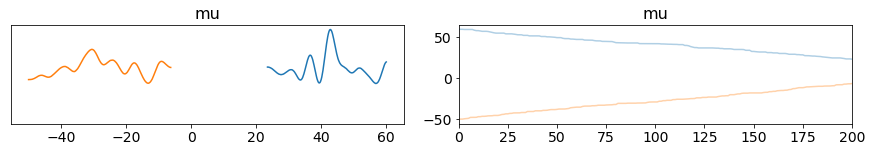

In [4]:
az.plot_trace(data_bad_init)

In this traceplot the chains have not converged to a single value. Both seem to be trending towards a value, but that value hasn't been reached. Additionally the posterior does not seem to follow any known distribution. This is concerning as we were expecting our model to exhibit a Gaussian behavior but it's hard to see one
In practice picking initialization points a challenge and a [number of strategies exist](https://docs.pymc.io/api/inference.html)

#### Suggested action
* Try different initialization strategies
* Run inference across more chains in different points

### Example 2: No Warmup Period
For purposes of learning we'll cheat again and manually set favorable (Close to 10) using prior knowledge, and then start running inference.
wever the first 20 samples are concerning as they seem to have a trend, and rather than exploring the posterior seem to still be in the process of converging.

In [5]:
start = time.time()
# "Better" Chain Starting points of 8 and 13
samples = 200
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=8)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=13)
data_good_init = az.from_dict({"mu":[chain_0, chain_1]}, dims={"chain":[0, 1]});
print(time.time()-start)

0.958411693572998


In [6]:
data_good_init

Inference data with groups:
	> posterior

In [7]:
data_good_init.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 201)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 193 194 195 196 197 198 199 200
Data variables:
    mu       (chain, draw) float64 8.0 8.0 8.0 8.0 ... 9.967 9.967 9.967 9.967
Attributes:
    created_at:  2019-04-29T06:29:54.387996

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa963cffcc0>,
      dtype=object)

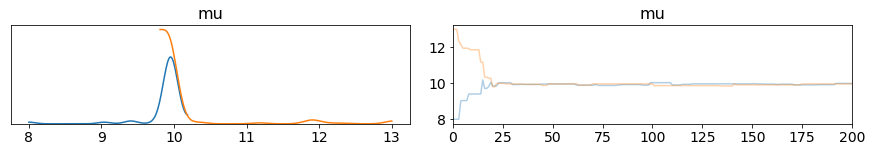

In [8]:
az.plot_trace(data_good_init)

The chains seem to have converged this time, reaching the approximate value of 10 even though they started above and below their final value. This gives us confidence that 10 is a correct value for the posterior. Still there are issues, Each individual chain seems to have only sampled one side of the distribution, and there clearly is a region at the start of correlated progress.

#### Suggested Actions
From the traceplot it looks like this model needs time to "warmup". Warmup samples are ones that samples that are discarded at the start of the chain while the chains begin to converge. 

* Discard samples near the start of a chain 

### Example: Same trace with warmup period
In our simple sampler we can discard the first 20 samples as warmup samples. This value was determined by looking at the trace plot and approximating where the chains meet.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa95d569f28>,
      dtype=object)

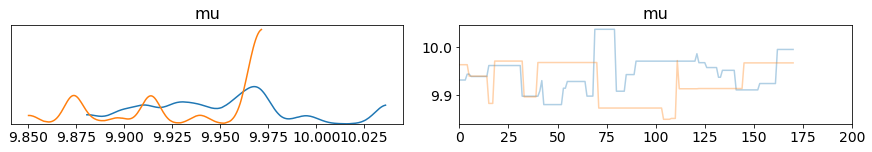

In [9]:
az.plot_trace(data_good_init.posterior.sel(draw=slice(30, None)))

This is a little better, the chains are now mixing fairly well and holding to a tight boundary. However the posterior plot and traceplot still raise concerns. The traceplot is still fairly "jagged" and which is also reflected a very odd distribution in the posterior plot. The Metropolis Hastings algorithm seems to have trouble exploring the distribution. One thing we could do is tune the Metropolis Hasting sampler, remember that there is a proposal distribution and acceptance criteria. By tuning these we could do better, but frankly speaking this is hard. 

We could also just take a lot more samples. 

#### Suggestions
* Tune the Metropolis Hastings Sampler (But this is both hard and annoying)
* Take a lot more samples

### Example: Same sampler with a lot more samples
As mentioned tuning the Metroplis Hastings algorithm is not fun. Thinking back to the theory, if we have sample an inifite amount of times then the samples will converge to the true posterior distribution. Let's just do the easy thing and run more samples.

In [10]:
start = time.time()

samples = 20000
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=8)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=13)
data_good_init_long_chain = az.from_dict({"mu":[chain_0, chain_1]}, dims={"chain":[0, 1]})

print(time.time()-start)

95.4359724521637


In [11]:
data_good_init_long_chain.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 20001)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 19995 19996 19997 19998 19999 20000
Data variables:
    mu       (chain, draw) float64 8.0 8.0 8.0 8.0 ... 9.945 9.945 9.945 9.945
Attributes:
    created_at:  2019-04-29T06:31:30.390007

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa94c490eb8>,
      dtype=object)

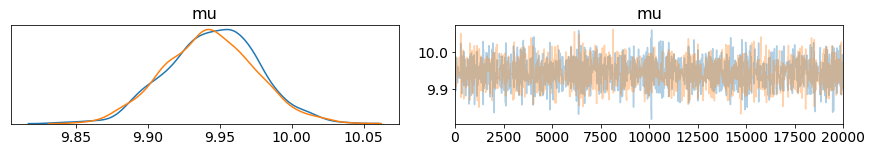

In [12]:
az.plot_trace(data_good_init_long_chain.posterior.sel(draw=slice(30, None)))

After 1.5 minutes on this computer the results look better. The traceplot is resembles a "fuzzy caterpillar", and both posterio chains look like a normal distribution, and more closely resemble each other. By taking a lot more samples we're able to get a posterior distribution that plausibly could be *mu*. 
  
We can use the same the strategy with the bad initialization as well if we take more samples and wait a bit longer.

In [13]:
start = time.time()

# "Randomly" pick -50 and 60 as start points but take a lot more samples this time
samples = 40000
chain_0 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=60)
chain_1 = metropolis_hastings.mh_sampler(data=data, samples=samples, mu_init=-50)
data_bad_init_longer_chain = az.from_dict({"mu":[chain_0, chain_1]}, dims={"chain":[0, 1]})

print(time.time()-start)

191.202082157135


In [14]:
data_bad_init_longer_chain.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 40001)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 39995 39996 39997 39998 39999 40000
Data variables:
    mu       (chain, draw) float64 60.0 59.67 59.67 59.66 ... 9.909 9.909 10.0
Attributes:
    created_at:  2019-04-29T06:34:41.913471

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa94c536a58>,
      dtype=object)

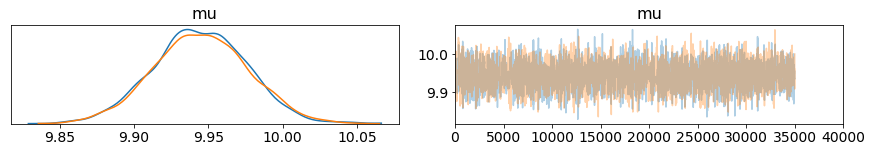

In [15]:
az.plot_trace(data_bad_init_longer_chain.posterior.sel(draw=slice(5000, None)))

After 3 minutes we have results. We need to throw away more samples, arbitrarily picking 5000, but the resulting plots look even better, and all we needed to do is wait longer. This is great news if you have infinite time and computing power. Unfortunately most humans don't live an infinite time span, nor do they want to be at work for an infinite amount of time so we need to do better.

### Better Living Through Physics

Stealing a title and quoting directly from [Richard McElreath's blog](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/)  
*If there’s a random way to do something, there’s usually a less random way that is both better and requires more thought. Instead of making random proposals, suppose instead that you run a physics simulation. This is going to sound crazy, but it isn’t.*  

What's he's referring to is Hamiltonian Based Samplers. At the core these samplers use principles from physics to select next points, think of riding a roller coaster with your eyes shut. By feeling how fast a roller coaster is going, you can deduce if you're at the bottom of the ride, or at the top. In addition to physics simulations PPLs such as PyMC3 and Stan implement various other tricks, called tuning, to help a Bayesian Modeler get good samples quickly with minimal fuss.

In [31]:
with pm.Model() as basic_model:
    θ = pm.Normal("θ", 0, 20)
    y = pm.Normal("y", mu=θ+20, observed=data)
    trace = pm.sample(5000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:02<00:00, 5961.71draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa94f4d9b70>,
      dtype=object)

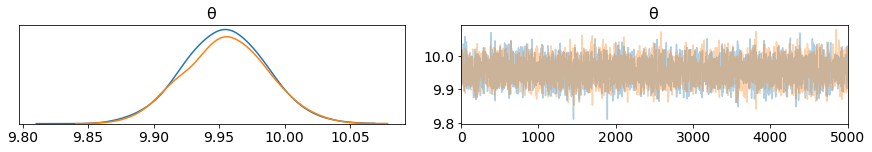

In [32]:
hmc_data = az.from_pymc3(trace=trace)
az.plot_trace(hmc_data)

# Section 1.2 Model Fitting

# Autocorrelation Plot
# Rank Plot

## Numerical Diagnostics
Numerical diagnostics are great for quickly understanding the characteristics of an MCMC chain. We will be covering two

* Effective Sample Size (ESS)
* Rhat

### Warning: Active Research Zone and history lession
Bayesian Statistics is an ever evolving field and in this tutorial and there are different versions of RHat and ESS. When reading results or using these methods be sure double check which version is being used. In this tutorial we'll ESS and Rhat calculations Vehtari Etal published in March of 2019.

[Aki Vehtari, Andrew Gelman, Daniel Simpson, Bob Carpenter, Paul-Christian Bürkner (2019): Rank-normalization, folding, and localization: An improved R-hat for assessing convergence of MCMC.](http://arxiv.org/abs/1903.08008)

Rhat and ESS calculations were first published as far back as 1992. The papers are linked here for reference. 

[Gelman and Rubin (1992)](https://projecteuclid.org/euclid.ss/1177011136)  
[Brooks and Gelman (1998)](http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeDiagnostics/BrooksGelman.pdf)  
[Gelman et al. Bayesian Data Analysis (2014)](http://www.stat.columbia.edu/~gelman/book/)